In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
df = pd.read_csv('Crashes.csv')

df['LONGITUDE'] = df['LONGITUDE'].fillna(df['POINT_X'])
df['LATITUDE'] = df['LATITUDE'].fillna(df['POINT_Y'])

df.columns

df = df.dropna(subset=['COLLISION_SEVERITY', 'LATITUDE', 'LONGITUDE'])

df.head()
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns: 
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Step 5: Create binary outcome variable for severity
df['IS_SEVERE'] = df['COLLISION_SEVERITY'].apply(lambda x: 1 if x in [1, 2] else 0)

# Step 6: Drop any completely empty rows, and forward-fill where it makes sense
df = df.dropna(how="all")

# Optional: Check missing value status
nan_count = df.isna().sum()
nan_pct = df.isna().sum() / len(df) * 100
print("Number of missing values per column:\n", nan_count)
print("\nPercentage of missing values:\n", nan_pct.round(2), "%")

# Preview cleaned data
df.head()
# Step 7: Convert to GeoDataFrame using lat/lon
collision_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']), crs='EPSG:4326')
collision_gdf = collision_gdf.to_crs('EPSG:3310')
collision_gdf['geometry'] = collision_gdf.geometry.buffer(2000)

# Step 8: Read CalEnviroScreen shapefile and filter for LA County
enviroscreen = gpd.read_file('CalEnviroScreen/CES4 Final Shapefile.shp')
enviroscreen = enviroscreen[enviroscreen.County == 'Los Angeles']

enviroscreen = enviroscreen.to_crs('EPSG:3310')

# Step 10: Spatial join — assign each collision to a census tract
collision_gdf = gpd.sjoin(collision_gdf, enviroscreen)
# Step 11: Calculate total and severe collision counts by tract
total_counts = collision_gdf.groupby('Tract').size()
severe_counts = collision_gdf.groupby('Tract')['IS_SEVERE'].sum()

# Step 12: Combine metrics into one DataFrame
tract_stats = pd.concat([total_counts, severe_counts], axis=1)
tract_stats.columns = ['n_collisions', 'n_severe_collisions']
tract_stats['pct_severe'] = tract_stats['n_severe_collisions'] / tract_stats['n_collisions']

# Step 13: Join stats back to enviroscreen
enviroscreen = enviroscreen.set_index('Tract').join(tract_stats)

# Step 14: Fill tracts with no collisions with 0s
enviroscreen[['n_collisions', 'n_severe_collisions', 'pct_severe']] = enviroscreen[
    ['n_collisions', 'n_severe_collisions', 'pct_severe']
].fillna(0)

# Step 15: Summary checks
print("Rows in collision_gdf after join:", len(collision_gdf))
print("\nSummary of collision metrics:")
print(enviroscreen[['n_collisions', 'n_severe_collisions', 'pct_severe']].describe())

Number of missing values per column:
 CASE_ID             0
ACCIDENT_YEAR       0
PROC_DATE           0
JURIS               0
COLLISION_DATE      0
                 ... 
COUNTY              0
CITY                0
POINT_X           297
POINT_Y           297
IS_SEVERE           0
Length: 81, dtype: int64

Percentage of missing values:
 CASE_ID           0.00
ACCIDENT_YEAR     0.00
PROC_DATE         0.00
JURIS             0.00
COLLISION_DATE    0.00
                  ... 
COUNTY            0.00
CITY              0.00
POINT_X           0.74
POINT_Y           0.74
IS_SEVERE         0.00
Length: 81, dtype: float64 %
Rows in collision_gdf after join: 757765

Summary of collision metrics:
       n_collisions  n_severe_collisions   pct_severe
count    2343.00000          2343.000000  2343.000000
mean      323.41656            38.351259     0.129628
std       188.49710            26.732217     0.068151
min         2.00000             0.000000     0.000000
25%       181.50000            19.50000

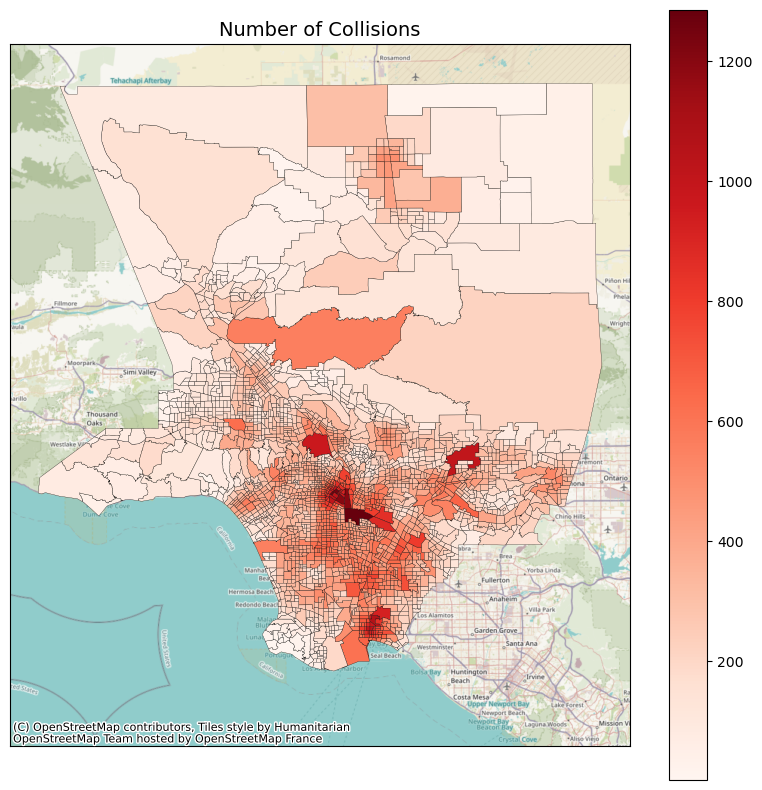

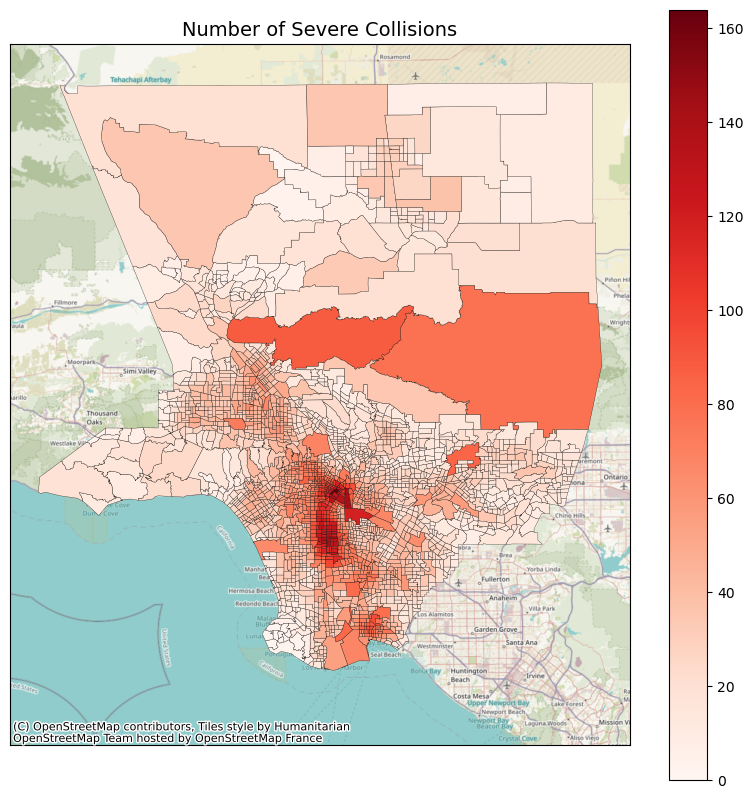

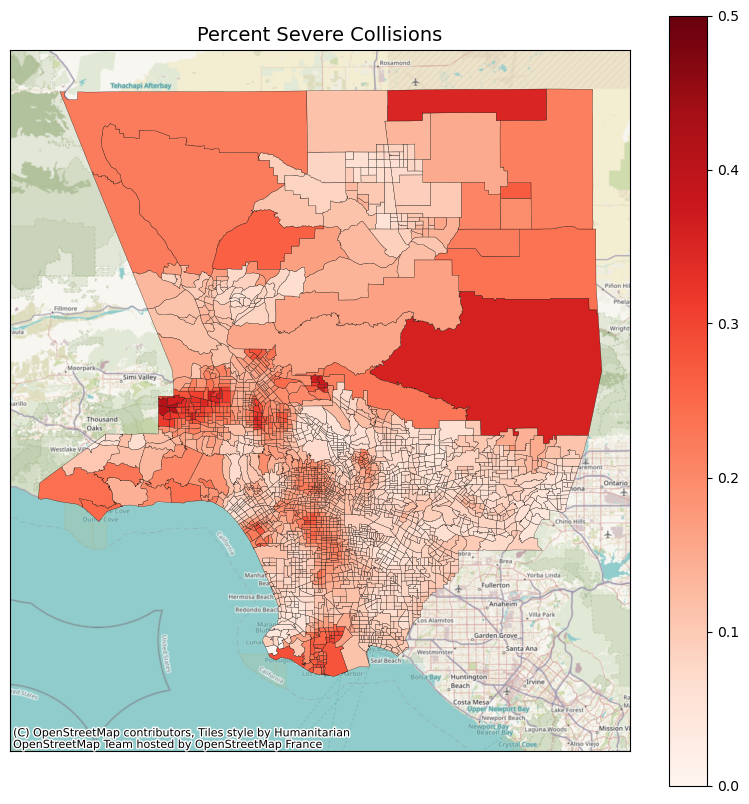

In [3]:
# Reproject Enviroscreen to Web Mercator
enviroscreen_web = enviroscreen.to_crs(epsg=3857)

# Plot maps for each desired column
for column, title in [
    ('n_collisions', 'Number of Collisions'),
    ('n_severe_collisions', 'Number of Severe Collisions'),
    ('pct_severe', 'Percent Severe Collisions')
]:
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot tract polygons colored by column values
    enviroscreen_web.plot(
        column=column,
        legend=True,
        cmap='Reds',
        ax=ax,
        edgecolor='black',
        linewidth=0.2,
        missing_kwds={'color': 'lightgrey'}
    )

    # Add basemap behind
    ctx.add_basemap(ax, zoom=10)

    # Clean up axis
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=14)

    # Optional: Zoom to LA mainland only (hide Catalina Island)
    ax.set_ylim(3970000, 4150000)

In [4]:
party_df = pd.read_csv('Parties.csv')
# Ensure CASEID column exists and is aligned
party_df = party_df[party_df['PARTY_AGE'] < 150]
used_codes = ['C', 'E', 'G', 'J', 'L', 'Q', 'W', 'Y', 'P']
party_df['SAFETY_USED'] = party_df['PARTY_SAFETY_EQUIP_1'].isin(used_codes).astype(int)
party_df['UNDER_INFLUENCE'] = ((party_df['PARTY_SOBRIETY'] == 'B') | (party_df['PARTY_DRUG_PHYSICAL'] == 'E')).astype(int)
party_df['AT_FAULT_FLAG'] = (party_df['AT_FAULT'] == 'Y').astype(int)
party_df['IS_MALE'] = (party_df['PARTY_SEX'] == 'M').astype(int)
party_df['DRUG_IMPAIRED'] = (party_df['PARTY_DRUG_PHYSICAL'] == 'E').astype(int)
party_df['HAS_INSURANCE'] = (party_df['FINAN_RESPONS'] == 'Y').astype(int)
party_df['IS_DRIVER'] = (party_df['PARTY_TYPE'] == 1).astype(int)

party_with_collision = party_df.merge(collision_gdf, on='CASE_ID', how='left')
party_with_collision.head()# Merge crash data into party level

C:\Users\eisha\AppData\Local\Temp\ipykernel_4744\716652314.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  party_df = pd.read_csv('Parties.csv')


,CASE_ID,PARTY_NUMBER,PARTY_TYPE,AT_FAULT,PARTY_SEX,PARTY_AGE,PARTY_SOBRIETY,PARTY_DRUG_PHYSICAL,DIR_OF_TRAVEL,PARTY_SAFETY_EQUIP_1,...,Pop_10_64,Elderly65,Hispanic,White,AfricanAm,NativeAm,OtherMult,Shape_Leng,Shape_Area,AAPI
0,91951222,1,1,Y,F,75,A,-,N,L,...,75.8972,12.2415,25.9761,46.5826,19.8368,0.0000,2.3370,28971.402214,4.933375e+07,5.2676
1,91951222,2,1,N,F,45,A,-,W,L,...,75.8972,12.2415,25.9761,46.5826,19.8368,0.0000,2.3370,28971.402214,4.933375e+07,5.2676
2,91951222,3,1,N,F,44,A,-,S,M,...,75.8972,12.2415,25.9761,46.5826,19.8368,0.0000,2.3370,28971.402214,4.933375e+07,5.2676
3,91947166,1,1,Y,F,32,A,-,W,M,...,78.4135,7.2549,57.2014,8.5383,16.3636,4.0463,1.1052,3758.522761,7.802893e+05,12.7451
4,91947166,1,1,Y,F,32,A,-,W,M,...,75.0839,5.3679,59.5840,5.4350,18.0720,0.0000,4.8311,3523.043910,6.159110e+05,12.0779


In [5]:
pd.set_option('display.max_columns', None)
display(party_with_collision)
party_with_collision.columns

,CASE_ID,PARTY_NUMBER,PARTY_TYPE,AT_FAULT,PARTY_SEX,PARTY_AGE,PARTY_SOBRIETY,PARTY_DRUG_PHYSICAL,DIR_OF_TRAVEL,PARTY_SAFETY_EQUIP_1,PARTY_SAFETY_EQUIP_2,FINAN_RESPONS,SP_INFO_1,SP_INFO_2,SP_INFO_3,OAF_VIOLATION_CODE,OAF_VIOL_CAT,OAF_VIOL_SECTION,OAF_VIOLATION_SUFFIX,OAF_1,OAF_2,PARTY_NUMBER_KILLED,PARTY_NUMBER_INJURED,MOVE_PRE_ACC,VEHICLE_YEAR,VEHICLE_MAKE,STWD_VEHICLE_TYPE,CHP_VEH_TYPE_TOWING,CHP_VEH_TYPE_TOWED,RACE,INATTENTION,SPECIAL_INFO_F,SPECIAL_INFO_G,ACCIDENT_YEAR_x,SAFETY_USED,UNDER_INFLUENCE,AT_FAULT_FLAG,IS_MALE,DRUG_IMPAIRED,HAS_INSURANCE,IS_DRIVER,ACCIDENT_YEAR_y,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,POPULATION,CNTY_CITY_LOC,SPECIAL_COND,BEAT_TYPE,CHP_BEAT_TYPE,CITY_DIVISION_LAPD,CHP_BEAT_CLASS,BEAT_NUMBER,PRIMARY_RD,SECONDARY_RD,DISTANCE,DIRECTION,INTERSECTION,WEATHER_1,WEATHER_2,STATE_HWY_IND,CALTRANS_COUNTY,CALTRANS_DISTRICT,STATE_ROUTE,ROUTE_SUFFIX,POSTMILE_PREFIX,POSTMILE,LOCATION_TYPE,RAMP_INTERSECTION,SIDE_OF_HWY,TOW_AWAY,COLLISION_SEVERITY,NUMBER_KILLED,NUMBER_INJURED,PARTY_COUNT,PRIMARY_COLL_FACTOR,PCF_CODE_OF_VIOL,PCF_VIOL_CATEGORY,PCF_VIOLATION,PCF_VIOL_SUBSECTION,HIT_AND_RUN,TYPE_OF_COLLISION,MVIW,PED_ACTION,ROAD_SURFACE,ROAD_COND_1,ROAD_COND_2,LIGHTING,CONTROL_DEVICE,CHP_ROAD_TYPE,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,NOT_PRIVATE_PROPERTY,ALCOHOL_INVOLVED,STWD_VEHTYPE_AT_FAULT,CHP_VEHTYPE_AT_FAULT,COUNT_SEVERE_INJ,COUNT_VISIBLE_INJ,COUNT_COMPLAINT_PAIN,COUNT_PED_KILLED,COUNT_PED_INJURED,COUNT_BICYCLIST_KILLED,COUNT_BICYCLIST_INJURED,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y,IS_SEVERE,geometry,index_right,Tract,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,PM2_5_P,DieselPM,DieselPM_P,Pesticide,PesticideP,Tox_Rel,Tox_Rel_P,Traffic,TrafficP,DrinkWat,DrinkWatP,Lead,Lead_P,Cleanup,CleanupP,GWThreat,GWThreatP,HazWaste,HazWasteP,ImpWatBod,ImpWatBodP,SolWaste,SolWasteP,PollBurd,PolBurdSc,PolBurdP,Asthma,AsthmaP,LowBirtWt,LowBirWP,Cardiovas,CardiovasP,Educatn,EducatP,Ling_Isol,Ling_IsolP,Poverty,PovertyP,Unempl,UnemplP,HousBurd,HousBurdP,PopChar,PopCharSc,PopCharP,Child_10,Pop_10_64,Elderly65,Hispanic,White,AfricanAm,NativeAm,OtherMult,Shape_Leng,Shape_Area,AAPI
0,91951222,1,1,Y,F,75,A,-,N,L,G,Y,-,3,-,-,-,NaN,NaN,N,-,0,1,B,2019.0,BUIC,A,7.0,NaN,W,NaN,-,-,2022,1,0,1,0,0,1,0,2022.0,2022-12-23,9545.0,2022-12-16,735.0,020140,NaN,5.0,1.0,9.0,1900.0,0.0,3.0,5,NaN,2.0,001,90TH STREET WEST,AVENUE K,0.0,NaN,Y,B,-,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,3.0,0.0,3.0,3.0,A,-,09,21802.0,A,N,D,C,A,A,H,-,A,A,0.0,NaN,NaN,NaN,NaN,Y,NaN,A,07,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-,-,34.674770,-118.289108,LOS ANGELES,UNINCORPORATED,-118.289131,34.674751,0.0,"POLYGON ((158700.709 -369879.421, 158691.079 -...",7621.0,6.037901e+09,93536.0,Los Angeles,Lancaster,10783.0,13.490478,21.671710,0.062365,88.699440,6.705407,5.675171,0.012695,4.754200,0.0,0.0,1046.845703,64.591148,173.535901,3.1625,590.144621,68.152866,26.074375,19.092628,2.00,25.625233,0.00,0.000000,0.110,19.245533,0.0,0.000000,0.0,0.000000,24.168714,2.950995,7.417548,57.76,66.525424,4.60,41.147036,13.66,58.287637,7.5,32.156416,2.6,20.584653,26.9,48.442211,4.8,41.840187,11.6,21.077313,44.070094,4.571501,41.212809,11.8613,75.8972,12.2415,25.9761,46.5826,19.8368,0.0000,2.3370,28971.402214,4.933375e+07,5.2676
1,91951222,2,1,N,F,45,A,-,W,L,G,Y,-,3,-,-,-,NaN,NaN,N,-,0,1,B,2018.0,BMW,A,1.0,NaN,W,NaN,-,-,2022,1,0,0,0,0,1,0,2022.0,2022-12-23,9545.0,2022-12-16,735.0,020140,NaN,5.0,1.0,9.0,1900.0,0.0,3.0,5,NaN,2.0,001,90TH STREET WEST,AVENUE K,0.0,NaN,Y,B,-,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,3.0,0.0,3.0,3.0,A,-,09,21802.0,A,N,D,C,A,A,H,-,A,A,0.0,NaN,NaN,NaN,NaN,Y,NaN,A,07,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-,-,34.674770,-118.289108,LOS ANGELES,UNINCORPORATED,-118.289131,34.674751,0.0,"POLYGON ((158700.709 -369879.421, 158691.079 -...",7621.0,6.037901e+09,93536.0,Los Angeles,Lancaster,10783.0,13.490478,2

Index(['CASE_ID', 'PARTY_NUMBER', 'PARTY_TYPE', 'AT_FAULT', 'PARTY_SEX',
       'PARTY_AGE', 'PARTY_SOBRIETY', 'PARTY_DRUG_PHYSICAL', 'DIR_OF_TRAVEL',
       'PARTY_SAFETY_EQUIP_1',
       ...
       'Pop_10_64', 'Elderly65', 'Hispanic', 'White', 'AfricanAm', 'NativeAm',
       'OtherMult', 'Shape_Leng', 'Shape_Area', 'AAPI'],
      dtype='object', length=189)

In [6]:
final_df = party_with_collision

In [7]:
column_list = final_df.columns.tolist()
print("\nColumns as a list:")
print(column_list)


Columns as a list:
['CASE_ID', 'PARTY_NUMBER', 'PARTY_TYPE', 'AT_FAULT', 'PARTY_SEX', 'PARTY_AGE', 'PARTY_SOBRIETY', 'PARTY_DRUG_PHYSICAL', 'DIR_OF_TRAVEL', 'PARTY_SAFETY_EQUIP_1', 'PARTY_SAFETY_EQUIP_2', 'FINAN_RESPONS', 'SP_INFO_1', 'SP_INFO_2', 'SP_INFO_3', 'OAF_VIOLATION_CODE', 'OAF_VIOL_CAT', 'OAF_VIOL_SECTION', 'OAF_VIOLATION_SUFFIX', 'OAF_1', 'OAF_2', 'PARTY_NUMBER_KILLED', 'PARTY_NUMBER_INJURED', 'MOVE_PRE_ACC', 'VEHICLE_YEAR', 'VEHICLE_MAKE', 'STWD_VEHICLE_TYPE', 'CHP_VEH_TYPE_TOWING', 'CHP_VEH_TYPE_TOWED', 'RACE', 'INATTENTION', 'SPECIAL_INFO_F', 'SPECIAL_INFO_G', 'ACCIDENT_YEAR_x', 'SAFETY_USED', 'UNDER_INFLUENCE', 'AT_FAULT_FLAG', 'IS_MALE', 'DRUG_IMPAIRED', 'HAS_INSURANCE', 'IS_DRIVER', 'ACCIDENT_YEAR_y', 'PROC_DATE', 'JURIS', 'COLLISION_DATE', 'COLLISION_TIME', 'OFFICER_ID', 'REPORTING_DISTRICT', 'DAY_OF_WEEK', 'CHP_SHIFT', 'POPULATION', 'CNTY_CITY_LOC', 'SPECIAL_COND', 'BEAT_TYPE', 'CHP_BEAT_TYPE', 'CITY_DIVISION_LAPD', 'CHP_BEAT_CLASS', 'BEAT_NUMBER', 'PRIMARY_RD', 'SE

C:\Users\eisha\AppData\Local\Temp\ipykernel_4744\2767719071.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = X[categorical_features].astype(str)


Training the Random Forest model...
Model training complete.

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    313376
         1.0       1.00      0.94      0.97     40082

    accuracy                           0.99    353458
   macro avg       1.00      0.97      0.98    353458
weighted avg       0.99      0.99      0.99    353458


Confusion Matrix:


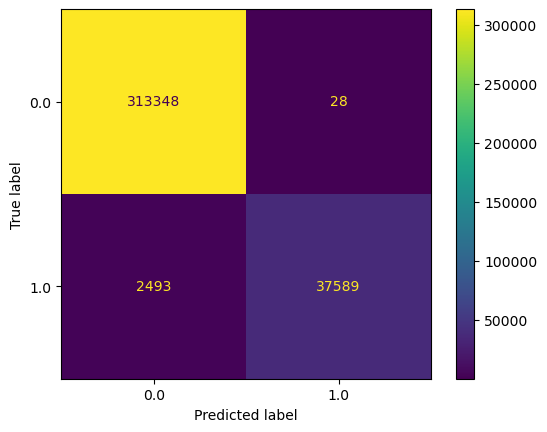

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

numeric_features = [
    'PARTY_AGE', 'VEHICLE_YEAR', 'COLLISION_TIME', 'LATITUDE', 'LONGITUDE', 'Traffic',
    'PM2_5', 'Poverty', 'Unempl', 'HousBurd', 'Asthma', 'Cardiovas',
    'Educatn', 'Ling_Isol', 'Hispanic', 'White', 'AfricanAm', 'NativeAm', 'AAPI'
]

categorical_features = [
    'PARTY_TYPE', 'PARTY_SEX', 'PARTY_SOBRIETY', 'PARTY_DRUG_PHYSICAL',
    'PARTY_SAFETY_EQUIP_1', 'STWD_VEHICLE_TYPE', 'RACE', 'MOVE_PRE_ACC',
    'TYPE_OF_COLLISION', 'PRIMARY_COLL_FACTOR', 'HIT_AND_RUN', 'DAY_OF_WEEK',
    'WEATHER_1', 'ROAD_SURFACE', 'LIGHTING', 'CONTROL_DEVICE', 'LOCATION_TYPE',
    'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT'
]

xvars = numeric_features + categorical_features
yvar = 'IS_SEVERE'

df_subset = final_df[xvars + [yvar]].dropna(subset=[yvar]).copy()
X = df_subset[xvars]
y = df_subset[yvar]

# Convert categorical columns to string type in case they are object type right now
X[categorical_features] = X[categorical_features].astype(str)

#split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


#rather than dropping rows with missing numerical values, we fill them with the median value to keep as much data as possible, while this may not make sense on a case by case basis, the overall model seems to be better for it
# after asking gemini, we found a technique the sci-kit learn has called a simpleimputer that works similar to replace, here's a website we used to understand it:
#https://www.geeksforgeeks.org/machine-learning/ml-handle-missing-data-with-simple-imputer/
numeric_imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data and transform 
X_train_numeric = pd.DataFrame(numeric_imputer.fit_transform(X_train[numeric_features]), columns=numeric_features)
X_test_numeric = pd.DataFrame(numeric_imputer.transform(X_test[numeric_features]), columns=numeric_features)


#we needed to do something similar for categorical data, and decided to choose most frequent as that would most likely be the best replacement
# Create an imputer for categorical data
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Fit on TRAINING data and transform both
X_train_categorical = pd.DataFrame(categorical_imputer.fit_transform(X_train[categorical_features]), columns=categorical_features)
X_test_categorical = pd.DataFrame(categorical_imputer.transform(X_test[categorical_features]), columns=categorical_features)

#after again asking gemini about how to deal with categorical data, at first we hoped to just encode letters to numbers directy with A being 1, B being 2 and so on, but after reading up on it we found that it isn't a good representation of categorical data and the model may falsely find patterns in numbers being less than or greater than each other. We then figured out how to use the one hot encoder through this website:
#https://www.geeksforgeeks.org/machine-learning/ml-one-hot-encoding/
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

X_train_encoded = one_hot_encoder.fit_transform(X_train_categorical)
X_test_encoded = one_hot_encoder.transform(X_test_categorical)

# Convert the results back to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))


# Reset index to ensure they concatenate correctly
X_train_numeric.reset_index(drop=True, inplace=True)
X_train_encoded_df.reset_index(drop=True, inplace=True)
X_test_numeric.reset_index(drop=True, inplace=True)
X_test_encoded_df.reset_index(drop=True, inplace=True)

# Combine the categorical and numerical columns
X_train_processed = pd.concat([X_train_numeric, X_train_encoded_df], axis=1)
X_test_processed = pd.concat([X_test_numeric, X_test_encoded_df], axis=1)


# --- 6. Train and Evaluate the Model ---
print("Training the Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=50, random_state=1)

# Fit the model on the fully processed training data
rf_model.fit(X_train_processed, y_train)
print("Model training complete.")

# Make predictions on the fully processed testing data
y_pred = rf_model.predict(X_test_processed)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
import seaborn as sns
print("\nCalculating and plotting feature importance...")

# Get importances from the trained model
importances = rf_model.feature_importances_

# Create a pandas Series, using the column names from the *processed* data
forest_importances = pd.Series(importances, index=X_train_processed.columns)

# Sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 12))
sns.barplot(x=forest_importances.values[:20], y=forest_importances.index[:20])
plt.title("Top 20 Feature Importances")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Features")
plt.tight_layout()

From the random forest model's confusion matrix we see that the model performed extremely well, likely due to the sheer amount of data it had to learn from as well as the variety of variables provided to use in prediction which was exciting to see. From the feature importances -- which is one of the main things we were hoping to test with this study, the results were somewhat to be expected, two out of the top three variables determining the severity of a crash are based on location and the other top factor was time of day. It is interesting however that from all the different factors we tested, party age and vehicle year are the next two most important features, even over pedestrian/motorcycle involvement. This lends to the idea that we should focus more time on public safety campaigns and policies that address both driver-centric risks for specific age groups and the significant safety advantages of modern vehicles. 